7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Enhanced Autoencoder Report:
              precision    recall  f1-score   support

           0       0.63      0.30      0.41       103
           1       0.52      0.81      0.64        97

    accuracy                           0.55       200
   macro avg       0.58      0.56      0.52       200
weighted avg       0.58      0.55      0.52       200



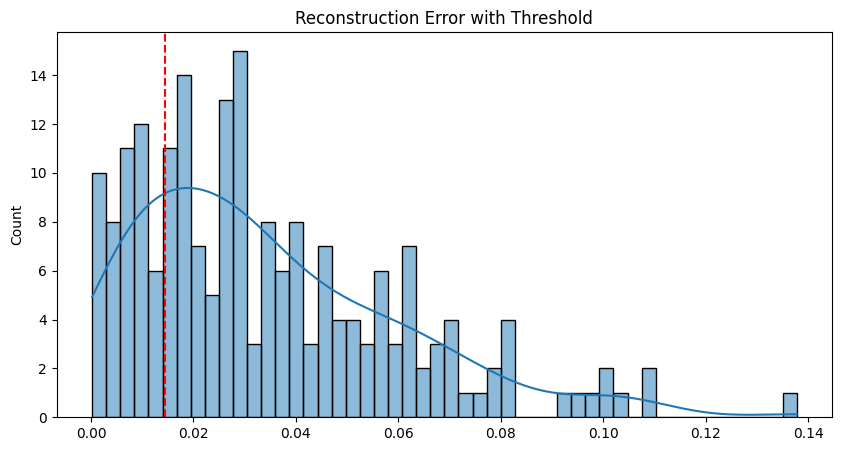


Model Comparison:
                      Accuracy  Precision    Recall  F1 Score
Enhanced Autoencoder     0.550   0.523179  0.814433  0.637097
Logistic Regression      0.510   0.495495  0.567010  0.528846
Random Forest            0.515   0.500000  0.505155  0.502564
Isolation Forest         0.525   0.600000  0.061856  0.112150
One-Class SVM            0.550   0.733333  0.113402  0.196429


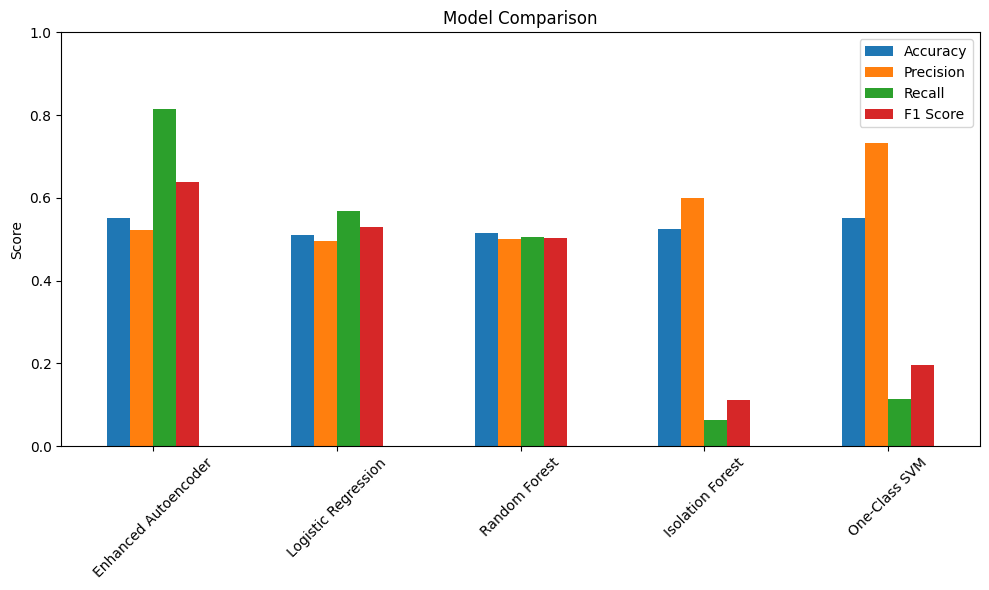

In [1]:
# Upi_Fraud_Enhanced_AE.ipynb (Python script style for export)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
import joblib
import pickle

# Load the dataset
df = pd.read_csv("transactions.csv")
df = df.drop(columns=["Transaction ID", "Timestamp", "Sender Name", "Receiver Name"], errors='ignore')
df['Sender UPI ID'] = LabelEncoder().fit_transform(df['Sender UPI ID'])
df['Receiver UPI ID'] = LabelEncoder().fit_transform(df['Receiver UPI ID'])
df['Status'] = df['Status'].apply(lambda x: 0 if x == 'SUCCESS' else 1)

# Feature and label prep
X = df[['Sender UPI ID', 'Receiver UPI ID', 'Amount (INR)']]
y = df['Status']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_norm = X_train[y_train == 0]

# Build Enhanced Autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32)(input_layer)
encoded = BatchNormalization()(encoded)
encoded = LeakyReLU()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(16)(encoded)
encoded = LeakyReLU()(encoded)
encoded = Dense(8)(encoded)
decoded = Dense(16)(encoded)
decoded = LeakyReLU()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(32)(decoded)
decoded = LeakyReLU()(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_norm, X_train_norm, epochs=100, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)
autoencoder.save("autoencoder_model.h5")

# Inference
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# ROC curve-based threshold selection
fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
y_pred_ae = [1 if e > threshold else 0 for e in mse]

# Evaluation
print("Enhanced Autoencoder Report:")
print(classification_report(y_test, y_pred_ae))

# Plot reconstruction error
plt.figure(figsize=(10,5))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Reconstruction Error with Threshold")
plt.savefig("reconstruction_error.png")
plt.show()

# Other models for comparison
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

iso = IsolationForest(contamination=0.05)
iso.fit(X_train)
y_pred_iso = iso.predict(X_test)
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]

svm = OneClassSVM(nu=0.05)
svm.fit(X_train[y_train == 0])
y_pred_svm = svm.predict(X_test)
y_pred_svm = [1 if i == -1 else 0 for i in y_pred_svm]

# Evaluate all
models = {
    "Enhanced Autoencoder": y_pred_ae,
    "Logistic Regression": y_pred_log,
    "Random Forest": y_pred_rf,
    "Isolation Forest": y_pred_iso,
    "One-Class SVM": y_pred_svm
}

metrics = {}
for name, pred in models.items():
    metrics[name] = {
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1 Score": f1_score(y_test, pred)
    }

df_metrics = pd.DataFrame(metrics).T
print("\nModel Comparison:")
print(df_metrics)

# Plot model comparison
df_metrics.plot(kind='bar', figsize=(10,6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()